In [1]:
import pandas as pd
import matplotlib
matplotlib.use('Qt4Agg')

import matplotlib.pyplot as plt
import numpy as np
from utils import utils

### Merge labels, coordinates and images in same df

In [2]:
df_labels = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

In [3]:
df = pd.read_csv('data/input_morphoJ.csv')
df['id'] = df['id'].apply(lambda x: x.split('.')[0])

In [4]:
from PIL import Image, ImageOps

def get_np(name, size=32):
    image =  Image.open('data/perfiles_CATA/png_full/' + name + '.png')
    image = image.resize((size, size), Image.ANTIALIAS)
    inverted_image =  1 - np.asarray(image)
    
    return inverted_image.ravel()

In [5]:
data = [[df.iloc[row][0], get_np(df.iloc[row][0])] for row in range(df.shape[0])]
df_images = pd.DataFrame(data=data, columns=['id', 'Image'])

In [6]:
merged_ = pd.merge(df_labels, df, how='inner', on=['id'])
#merged = pd.merge(df_labels, df, how='inner', on=['id'])
merged = pd.merge(df_labels, df_images, how='inner', on=['id'])

### Check # of elements per class

In [7]:
grouped = merged.groupby('class')
for name, group in grouped:
    print(name, group.shape)
merged.shape

1 (30, 3)
2 (47, 3)
3 (75, 3)
4 (10, 3)
5 (56, 3)
6 (52, 3)
7 (50, 3)
8 (293, 3)
9 (22, 3)
10 (372, 3)
11 (125, 3)


(1132, 3)

### Plot t-SNE of raw images

In [8]:
files = ["data/perfiles_CATA/png_full/"+i+".png" for i in np.array(merged["id"])]

In [9]:
_merged = pd.DataFrame()
_merged[0] = files
_merged[1] = merged['class']

Computing t-SNE embedding of the 11 classes of  vessel


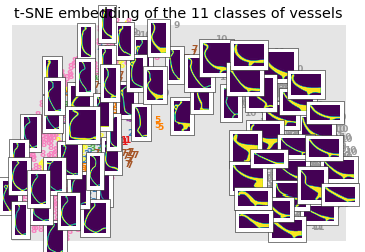

In [10]:
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
from time import time
from utils import utils
from sklearn import manifold

id_ =  merged['id']
class_ = merged['class']
#merged_tsne_2d = merged.drop(['id', 'class'], axis=1)

print("Computing t-SNE embedding of the 11 classes of  vessel")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#t0 = time()
#print(merged.values)
X_tsne = tsne.fit_transform(np.array(merged['Image'].tolist()))
utils.plot_embedding(X_tsne, _merged,
               "t-SNE embedding of the 11 classes of vessels")

plt.grid()
plt.show()


### Now plot in 3D with images ..

In [11]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.array(merged['Image'].tolist()))

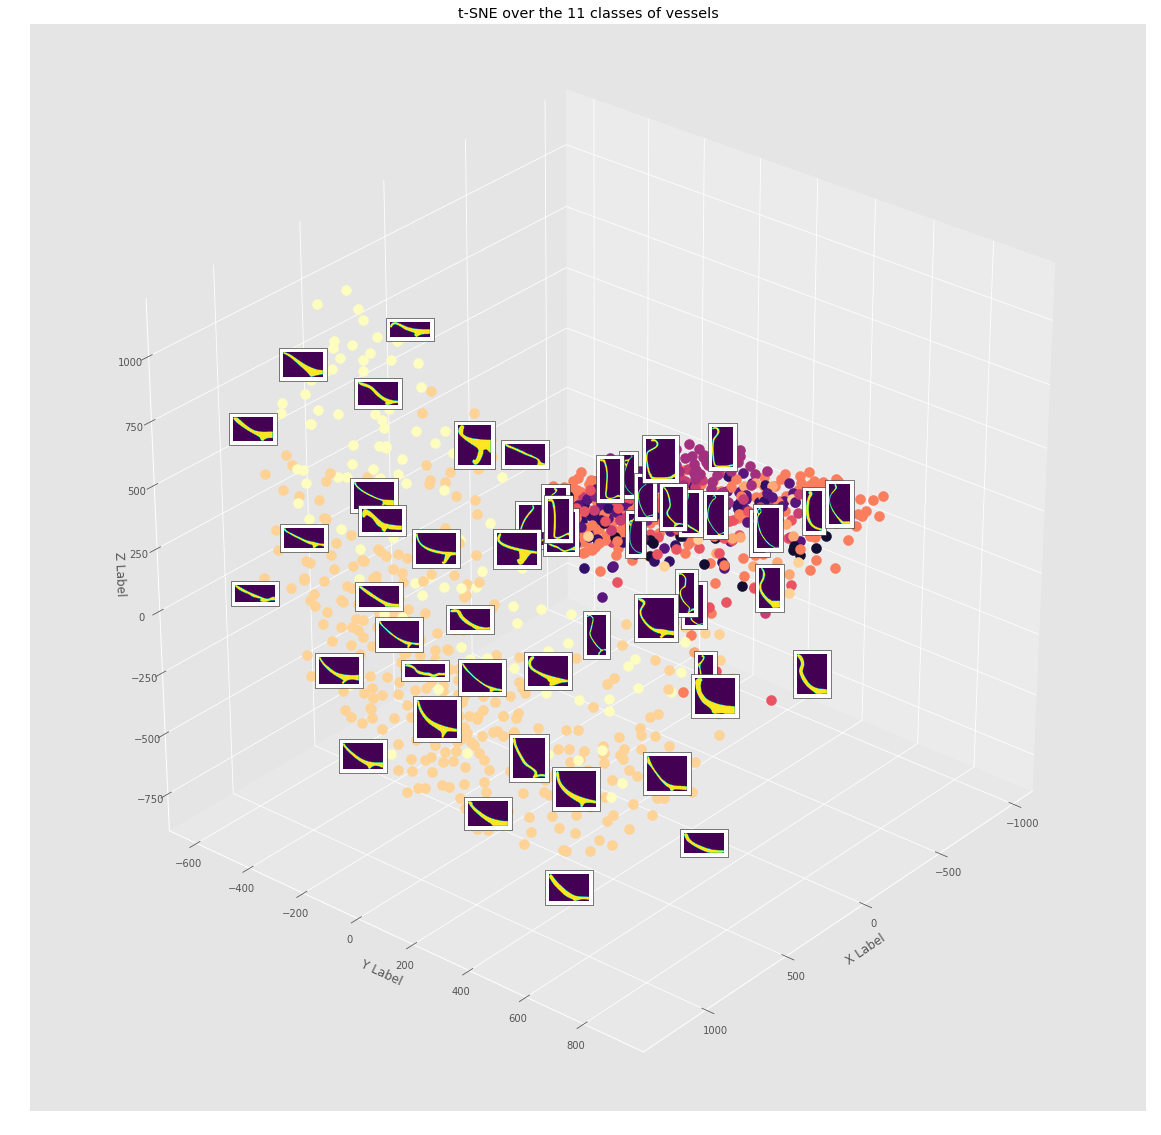

In [12]:
#for ii in range(0, 360, 5):
utils.plot_tsne_3D(X_tsne, merged, azim=40)

### PCA

In [13]:
from sklearn.decomposition import PCA # using randomized Singular Value Decomposition

id_ =  merged['id']
class_ = merged['class']
merged = merged.drop(['id', 'class'], axis=1)
Xp = PCA(svd_solver='randomized', n_components=2, random_state=1).fit_transform(np.array(merged['Image'].tolist()))
Xp

array([[-205.75711109,  289.87597641],
       [-223.97536348,  247.33984032],
       [-166.35596739,   80.97645153],
       ...,
       [ 618.25075413, -367.28096557],
       [ 641.13850946,   16.59624255],
       [ 290.13366804,  364.87242287]])

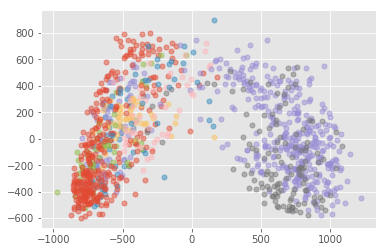

In [14]:
%matplotlib inline
pca_df = pd.DataFrame(Xp, columns=['x', 'y'])
pca_df = pd.concat([id_, class_, pca_df], axis=1)
pca_df

groups = pca_df.groupby('class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    if name in range(12): # 11, 10 y 9
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name, alpha=0.5)
        #print(group)
        #for i, row in group.iterrows():
            #print(row.id)
            #ax.annotate(row.id, (row.x, row.y), alpha=0.5)

#ax.set_xlim([-7000, 50000])
#ax.set_ylim([-3000, 6000])
#ax.legend()
plt.show()

### KMEANS clustering for geometric vessel clusters

number of estimated clusters : 11


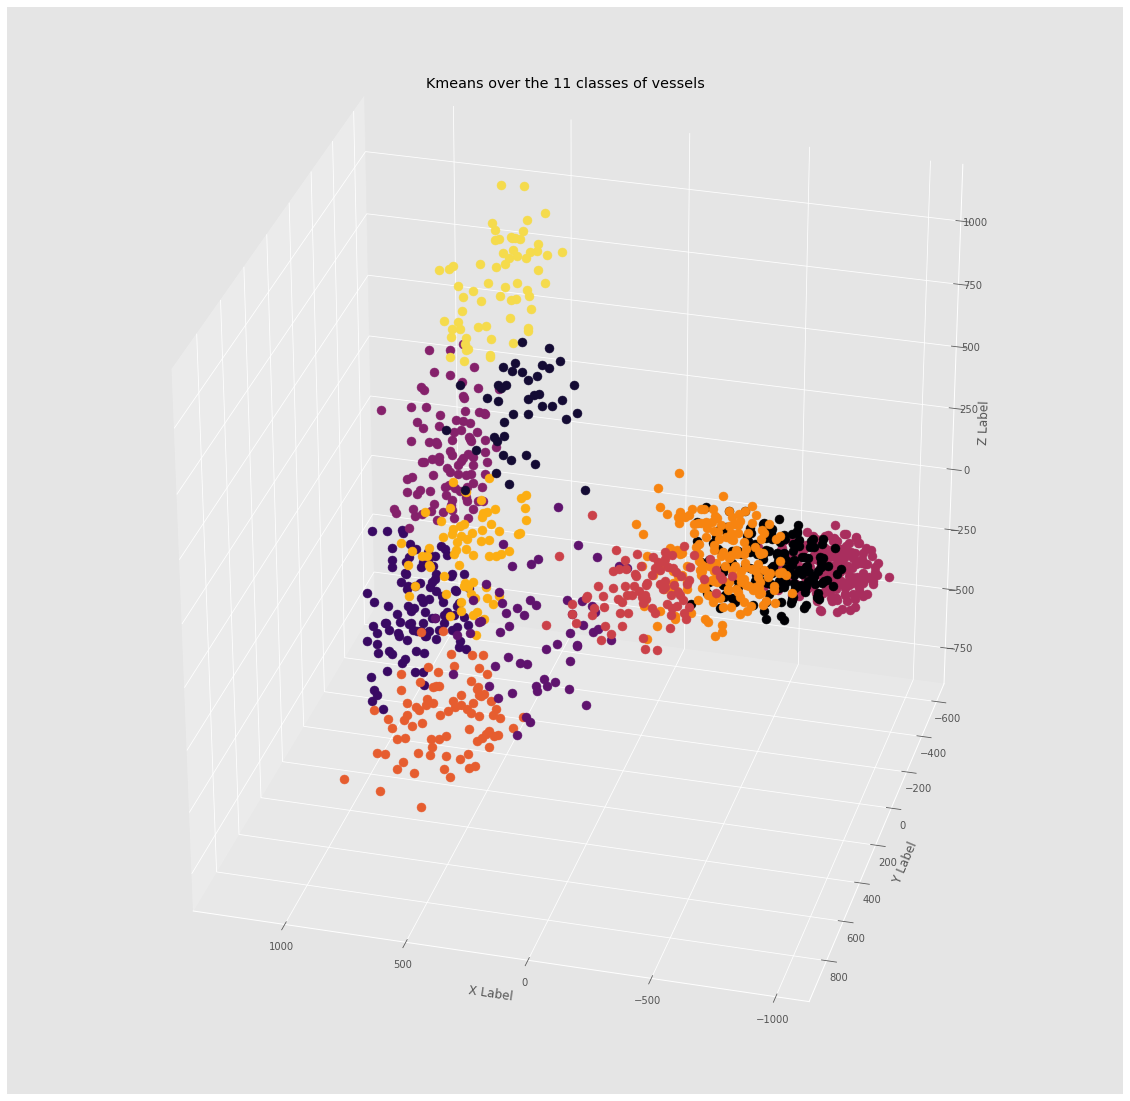

In [15]:
from sklearn.cluster import KMeans
from matplotlib import offsetbox
import PIL
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d


kmeans_model = KMeans(n_clusters=11, random_state=42).fit(X_tsne)
labels = kmeans_model.predict(X_tsne)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=Axes3D.name)
ax.view_init(elev=30., azim=105)
for i in range(X_tsne.shape[0]):
        ax.scatter(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], color=plt.cm.inferno(labels[i] / 11.), s=80)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.legend()
plt.title('Kmeans over the 11 classes of vessels')
#plt.savefig("/tmp/movie%d.png" % ii)
plt.show()


### Procrustes method

In [16]:
class Shape(object):
        def __init__(self, landmarks, name):
            self.xy = np.array(landmarks, dtype=np.float)
            self.nr_landmarks =  self.xy.shape[0]/2
            self.name = name
            self.centroid = self.get_centroid()

        def load_shape(self, shape):
            pass

        def translate_shape(self, direction):

            T = np.identity(3)
            T[:2, 2] = direction[:2]

            return T

        def get_centroid(self):
            centroid = self.xy.mean(0)
            return centroid

        def align_shape(self, mean_shape):
            """
            Procrustes fit
            """
            n, m = mean_shape.xy.shape
            ny, my = self.xy.shape
            reflection = 'best'
            scaling = True

            X0 = mean_shape.xy - mean_shape.centroid
            Y0 = self.xy - self.centroid

            ssX = (X0**2.).sum()
            ssY = (Y0**2.).sum()
            
            # centred Frobenius norm
            normX = np.sqrt(ssX)
            normY = np.sqrt(ssY)

            # scale to equal (unit) norm
            X0 /= normX
            Y0 /= normY

            if my < m:
                Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)
            # optimum rotation matrix of Y
            A = np.dot(X0.T, Y0)
            U,s,Vt = np.linalg.svd(A,full_matrices=False)
            V = Vt.T
            T = np.dot(V, U.T)

            if reflection is not 'best':

                # does the current solution use a reflection?
                have_reflection = np.linalg.det(T) < 0
                # if that's not what was specified, force another reflection
                if reflection != have_reflection:
                    V[:,-1] *= -1
                    s[-1] *= -1
                    T = np.dot(V, U.T)

            traceTA = s.sum()

            if scaling:

                # optimum scaling of Y
                b = traceTA * normX / normY

                # standarised distance between X and b*Y*T + c
                d = 1 - traceTA**2

                # transformed coords
                Z = normX*traceTA*np.dot(Y0, T) + mean_shape.centroid

            else:
                b = 1
                d = 1 + ssY/ssX - 2 * traceTA * normY / normX
                Z = normY*np.dot(Y0, T) + mean_shape.centroid

            # transformation matrix
            if my < m:
                T = T[:my,:]
            c = mean_shape.centroid - b*np.dot(self.centroid, T)

            #transformation values 
            tform = {'rotation':T, 'scale':b, 'translation':c}

            self.xy = Z.copy()
            #print d

        def plot_shape(self, color=''):
            return plt.plot(self.xy[:,1], self.xy[:,0], 'o'+color)

/home/pablo/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


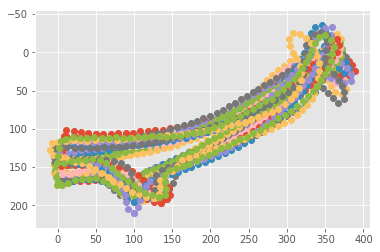

In [17]:
plt.style.use('ggplot')

my_shapes = list()
for index, row in df.iterrows():
    my_shapes.append(Shape(row[1:].values.reshape((100, 2)), row[0]))

for shape in my_shapes:
    shape.align_shape(my_shapes[0])    
for shape in my_shapes[:20]:
    shape.plot_shape()

plt.axes().set_aspect('equal', 'datalim')
plt.gca().invert_yaxis()
plt.show()

In [18]:
df_procrustes = pd.DataFrame(columns=range(200))
for index, shape in enumerate(my_shapes):
    df_procrustes.loc[index] = my_shapes[index].xy.reshape((200,))
df_procrustes.to_csv('data/procrustes_coordinates_homemade.txt', index=None)